# Tutorial

In [ ]:
from IPython.display import display, Image
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# these lines of code are to be used if using the binder instance. Ignore otherwise!
import sys
sys.path.append('../../../')
from magine.copy_sample_dbs import copy_sample_databases
# This uses the a cached version of the databases to speed up the tutorial
copy_sample_databases()

Database directories already exist. Override using force=True argument. Skipping...


In [2]:
import pandas as pd
import seaborn as sns
import numpy as np

c:\users\pinojc\miniconda3\envs\magine_37\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## ExperimentalData 

Since MAGINE is built for multi-sample, multi-omics data, it is no surprise that the data is the most important aspect. Here we should how to use the :py:class:`ExperimentalData` class. We designed MAGINE data input to be as flexible as possible, requiring a standard format for 8 columns. Users are required to format the input files to share the same column names. Additional columns can still be used for additional tags on the data. 

For this tutorial, we are going to use our time series multi-omic response of A549 cells to cisplatin. 

The description of the experiments and dataset can be found in  [Norris, Jeremy L., et al.](https://pubs.acs.org/doi/abs/10.1021/acs.jproteome.6b01004)

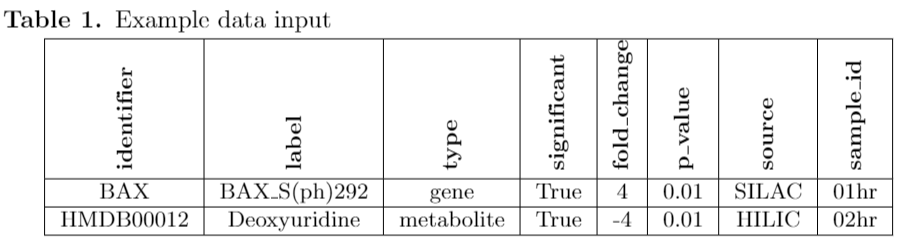

In [4]:
Image('data_sample.png')

In [3]:
# load the experimental data
from magine.data.experimental_data import load_data

exp_data = load_data('Data/norris_et_al_2017_cisplatin_data.csv.gz', low_memory=False)

In [4]:
help(exp_data)

Help on ExperimentalData in module magine.data.experimental_data object:

class ExperimentalData(builtins.object)
 |  ExperimentalData(data_file)
 |  
 |  Manages all experimental data
 |  
 |  Methods defined here:
 |  
 |  __getitem__(self, name)
 |  
 |  __init__(self, data_file)
 |      Parameters
 |      ----------
 |      data_file : str, pandas.DataFrame
 |          Name of file, generally csv.
 |          If provided a str, the file will be read in as a pandas.DataFrame
 |  
 |  __setattr__(self, name, value)
 |      Implement setattr(self, name, value).
 |  
 |  create_summary_table(self, sig=False, index='identifier', save_name=None, plot=False, write_latex=False)
 |      Creates a summary table of data.
 |      
 |      
 |      Parameters
 |      ----------
 |      sig: bool
 |          Flag to summarize significant species only
 |      save_name: str
 |          Name to save csv and .tex file
 |      index: str
 |         Index for counts
 |      plot: bool
 |          If 

### About the data


There are 4 time points and 6 experimental platforms. 

In [5]:
exp_data.sample_ids

['01hr', '06hr', '24hr', '48hr']

In [6]:
exp_data.exp_methods

['rna_seq', 'ph_silac', 'label_free', 'silac', 'C18', 'HILIC']

We created a function to quickly get the numbers of measured per time point and platform. Additional arguments can be used to get counts of only signficantly changes species (marked by `signficant_flag` column of input data).

In [7]:
display(exp_data.create_summary_table())
display(exp_data.create_summary_table(sig=True))

sample_id,01hr,06hr,24hr,48hr,Total Unique Across
source,,,,,
C18,522,227,653,685,1402
HILIC,471,605,930,613,1504
label_free,2766,2742,2551,2261,3447
ph_silac,2608,3298,3384,3236,5113
rna_seq,18741,19104,19992,-,20642
silac,2923,3357,3072,3265,4086


sample_id,01hr,06hr,24hr,48hr,Total Unique Across
source,,,,,
C18,522,227,653,685,1402
HILIC,471,605,930,613,1504
label_free,196,46,271,874,1085
ph_silac,514,888,1227,851,2278
rna_seq,73,1999,12215,-,12340
silac,38,52,228,266,485


MAGINE uses the `identifier` column as the default index. This keeps things simple when using the output for other tools (passing to molecular networks). You can also pass an index argument to calculate other values. Here, we use the `label` column, which contains PTMs of our protein species. See how `silac` values do not change, but there is an increase number of `ph_silac` unique species. 

In [10]:
display(exp_data.create_summary_table(sig=True, index='label'))

sample_id,01hr,06hr,24hr,48hr,Total Unique Across
source,,,,,
C18,528,227,657,689,1412
HILIC,479,611,941,621,1521
label_free,201,46,281,911,1149
ph_silac,594,1370,2414,1368,4757
rna_seq,73,1999,12215,-,12340
silac,38,52,228,266,485


### Filter  by category (experimental method)

We can access the input data using the `.species` property. This returns a modified pandas.Datatable.

MAGINE uses the `species_type` and `source` column name to split data into `compounds`, `genes` (includes `species_type`==`gene`), `rna` (includes `species_type`==`gene`, `source` == `rna`), or `protein` (`species_type`==`gene`, `source` != `rna`). 
They can be accessed with the ".prefix", such as


In [8]:
exp_data.genes.head(5)

,identifier,label,species_type,fold_change,p_value,significant,sample_id,source
0,HOXD1,HOXD1_rnaseq,protein,-520.256762,0.00102,True,06hr,rna_seq
1,MIR7704,MIR7704_rnaseq,protein,-520.256762,0.00102,True,06hr,rna_seq
2,AC078814.1,AC078814.1_rnaseq,protein,-76.022260,0.00102,True,06hr,rna_seq
3,PPM1H,PPM1H_rnaseq,protein,-76.022260,0.00102,True,06hr,rna_seq
4,PLCH1,PLCH1_rnaseq,protein,-17.888990,0.00102,True,06hr,rna_seq


In [9]:
exp_data.compounds.head(5)

,identifier,label,species_type,fold_change,p_value,significant,sample_id,source
128152,HMDB0036114,(-)-3-Thujone,metabolites,1.6,2.100000e-02,True,06hr,C18
128153,HMDB0001320,"(13E)-11a-Hydroxy-9,15-dioxoprost-13-enoic acid",metabolites,88.8,5.800000e-12,True,24hr,C18
128154,HMDB0012113,(22Alpha)-hydroxy-campest-4-en-3-one,metabolites,100.0,9.500000e-04,True,48hr,HILIC
128155,HMDB0010361,"(23S)-23,25-dihdroxy-24-oxovitamine D3 23-(bet...",metabolites,-100.0,1.000000e-12,True,48hr,C18
128156,HMDB0011644,"(24R)-Cholest-5-ene-3-beta,7-alpha,24-triol",metabolites,1.6,7.400000e-05,True,01hr,C18


Similarily, we can also filter the data by `source` using the `.name`, where name is anything in the `source` column. We can get a list of these by printing `exp_data.exp_methods`. 


In [10]:
# prints all the available exp_methods
exp_data.exp_methods

['rna_seq', 'ph_silac', 'label_free', 'silac', 'C18', 'HILIC']

In [11]:
# filters to only the 'label_free' 
exp_data.label_free.shape

(13085, 8)

In [12]:
exp_data.label_free.head(5)

,identifier,label,species_type,fold_change,p_value,significant,sample_id,source
102446,LIMS1,LIMS1_lf,protein,12.42,0.00003,True,01hr,label_free
102447,SMARCE1,SMARCE1_lf,protein,-2.49,0.00030,True,01hr,label_free
102448,HEXA,HEXA_lf,protein,6.42,0.00060,True,01hr,label_free
102449,SRSF1,SRSF1_lf,protein,-3.21,0.00060,True,01hr,label_free
102450,SF3B1,SF3B1_lf,protein,-1.57,0.00130,True,01hr,label_free


In [13]:
exp_data.HILIC.head(5)

,identifier,label,species_type,fold_change,p_value,significant,sample_id,source
128154,HMDB0012113,(22Alpha)-hydroxy-campest-4-en-3-one,metabolites,100.0,0.000950,True,48hr,HILIC
128157,HMDB0011644,"(24R)-Cholest-5-ene-3-beta,7-alpha,24-triol",metabolites,1.7,0.000072,True,24hr,HILIC
128162,HMDB0012114,"(3S)-3,6-Diaminohexanoate",metabolites,-1.9,0.000030,True,06hr,HILIC
128164,HMDB0012114,"(3S)-3,6-Diaminohexanoate",metabolites,-3.0,0.002000,True,24hr,HILIC
128166,HMDB0012115,"(3S,5S)-3,5-Diaminohexanoate",metabolites,-1.9,0.000030,True,06hr,HILIC


### Significant filter 
We can use the `significant` column to filter that data to only contain those species.

In [14]:
exp_data.species.shape

(132932, 8)

In [15]:
exp_data.species.sig.shape

(27288, 8)

### Filter data to up or down regulated species.


For enrichment analysis, we will want to access up-regulated and down-regulated species using `.up` and `.down`.

In [16]:
exp_data.rna_seq.up.head(10)

,identifier,label,species_type,fold_change,p_value,significant,sample_id,source
13,DLX2,DLX2_rnaseq,protein,2.874358,0.001020,True,06hr,rna_seq
18,RETSAT,RETSAT_rnaseq,protein,2.325934,0.001020,True,06hr,rna_seq
21,SLC52A1,SLC52A1_rnaseq,protein,2.871869,0.001020,True,06hr,rna_seq
24,OTUD3,OTUD3_rnaseq,protein,1.821775,0.001020,True,06hr,rna_seq
35,RP11-209D14.2,RP11-209D14.2_rnaseq,protein,1.819533,0.025204,True,06hr,rna_seq
58,ZNF554,ZNF554_rnaseq,protein,2.309691,0.004153,True,06hr,rna_seq
59,FZD9,FZD9_rnaseq,protein,1.812798,0.001020,True,06hr,rna_seq
71,SBK1,SBK1_rnaseq,protein,1.806427,0.002689,True,06hr,rna_seq
88,PPM1D,PPM1D_rnaseq,protein,1.803186,0.001020,True,06hr,rna_seq
92,ZNF425,ZNF425_rnaseq,protein,2.846581,0.001020,True,06hr,rna_seq


In [17]:
exp_data.rna_seq.down.head(10)

,identifier,label,species_type,fold_change,p_value,significant,sample_id,source
0,HOXD1,HOXD1_rnaseq,protein,-520.256762,0.001020,True,06hr,rna_seq
1,MIR7704,MIR7704_rnaseq,protein,-520.256762,0.001020,True,06hr,rna_seq
2,AC078814.1,AC078814.1_rnaseq,protein,-76.022260,0.001020,True,06hr,rna_seq
3,PPM1H,PPM1H_rnaseq,protein,-76.022260,0.001020,True,06hr,rna_seq
4,PLCH1,PLCH1_rnaseq,protein,-17.888990,0.001020,True,06hr,rna_seq
5,RP11-639F1.1,RP11-639F1.1_rnaseq,protein,-17.888990,0.001020,True,06hr,rna_seq
6,TP63,TP63_rnaseq,protein,-12.355659,0.001020,True,06hr,rna_seq
7,JARID2,JARID2_rnaseq,protein,-7.891502,0.001020,True,06hr,rna_seq
8,GLI2,GLI2_rnaseq,protein,-5.389009,0.001020,True,06hr,rna_seq
9,MAP3K5,MAP3K5_rnaseq,protein,-4.262353,0.001893,True,06hr,rna_seq


### Extracting by sample (time point)

We also added an index filter to segregate by `sample_id`.

In [18]:
for i in exp_data.sample_ids:
    print(i)
    display(exp_data[i].head(5))

01hr


,identifier,label,species_type,fold_change,p_value,significant,sample_id,source
19160,GRIK4,GRIK4_rnaseq,protein,77.555651,0.019824,True,01hr,rna_seq
19161,GRIK4_3p_UTR,GRIK4_3p_UTR_rnaseq,protein,77.555651,0.019824,True,01hr,rna_seq
19162,AP001187.9,AP001187.9_rnaseq,protein,-25.455050,0.019824,True,01hr,rna_seq
19163,MIR192,MIR192_rnaseq,protein,-25.455050,0.019824,True,01hr,rna_seq
19164,MIR194-2,MIR194-2_rnaseq,protein,-25.455050,0.019824,True,01hr,rna_seq


06hr


,identifier,label,species_type,fold_change,p_value,significant,sample_id,source
0,HOXD1,HOXD1_rnaseq,protein,-520.256762,0.00102,True,06hr,rna_seq
1,MIR7704,MIR7704_rnaseq,protein,-520.256762,0.00102,True,06hr,rna_seq
2,AC078814.1,AC078814.1_rnaseq,protein,-76.022260,0.00102,True,06hr,rna_seq
3,PPM1H,PPM1H_rnaseq,protein,-76.022260,0.00102,True,06hr,rna_seq
4,PLCH1,PLCH1_rnaseq,protein,-17.888990,0.00102,True,06hr,rna_seq


24hr


,identifier,label,species_type,fold_change,p_value,significant,sample_id,source
37960,LHX3,LHX3_rnaseq,protein,202.225343,0.005180,True,24hr,rna_seq
37961,C17orf67,C17orf67_rnaseq,protein,2.571464,0.000123,True,24hr,rna_seq
37962,ALX1,ALX1_rnaseq,protein,-2.572587,0.000123,True,24hr,rna_seq
37963,MIR7844,MIR7844_rnaseq,protein,2.573033,0.009349,True,24hr,rna_seq
37964,TMCC3,TMCC3_rnaseq,protein,2.573033,0.009349,True,24hr,rna_seq


48hr


,identifier,label,species_type,fold_change,p_value,significant,sample_id,source
58025,TNS3,TNS3_1188_1197_phsilac,protein,-3.837129,0.049,True,48hr,ph_silac
58026,SIPA1L3,SIPA1L3_S(ph)158_phsilac,protein,-5.119600,0.049,True,48hr,ph_silac
58027,TNS3,TNS3_Y(ph)780_phsilac,protein,-4.986421,0.049,True,48hr,ph_silac
58028,FGD6,FGD6_S(ph)554_phsilac,protein,-3.900705,0.049,True,48hr,ph_silac
58029,GPN1,GPN1_S(ph)312_phsilac,protein,2.901199,0.049,True,48hr,ph_silac


In [19]:
exp_data['01hr'].head(5)

,identifier,label,species_type,fold_change,p_value,significant,sample_id,source
19160,GRIK4,GRIK4_rnaseq,protein,77.555651,0.019824,True,01hr,rna_seq
19161,GRIK4_3p_UTR,GRIK4_3p_UTR_rnaseq,protein,77.555651,0.019824,True,01hr,rna_seq
19162,AP001187.9,AP001187.9_rnaseq,protein,-25.455050,0.019824,True,01hr,rna_seq
19163,MIR192,MIR192_rnaseq,protein,-25.455050,0.019824,True,01hr,rna_seq
19164,MIR194-2,MIR194-2_rnaseq,protein,-25.455050,0.019824,True,01hr,rna_seq


### Pivot table to get table across time
We also provide a function to quickly pivot the data to for easy export. 

In [20]:
exp_data.label_free.pivoter(
    convert_to_log=False, 
    index='identifier',
    columns='sample_id',
    values=['fold_change', 'p_value']
).head(10)

fold_change                        p_value                    \
sample_id         01hr   06hr   24hr   48hr      01hr     06hr     24hr   
identifier                                                                
A2M           1.040000  1.140  51.93  11.58  0.514800  0.44370  0.24260   
AACS         -1.100000  3.740    NaN    NaN  0.281800  0.26950      NaN   
AAGAB         1.000000 -1.150   1.46  -2.03  0.968100  0.39240  0.84450   
AAK1          1.320000  1.590    NaN   1.72  0.715800  0.18110      NaN   
AAMP         -1.200000 -1.460   1.85   1.78  0.836800  0.55420  0.13640   
AAR2               NaN -1.690    NaN    NaN       NaN  0.96510      NaN   
AARS          0.326667 -0.035  -1.44  -3.12  0.299867  0.62425  0.46725   
AARS2         1.170000    NaN    NaN    NaN  0.253000      NaN      NaN   
AARSD1        1.210000  4.070  -2.05    NaN  0.459700  0.49160  0.78440   
AASDHPPT     -0.330000  1.020   1.07  -1.11  0.709600  0.81160  0.45290   

                     
sample_id      48hr  
identifier           
A2M         0.11130  
AACS            NaN  
AAGAB       0.09760  
AAK1        0.95660  
AAMP        0.32460  
AAR2            NaN  
AARS        0.00045  
AARS2           NaN  
AARSD1          NaN  
AASDHPPT    0.00070

Note that in the previous two examples, we find that there are NaN values. This is because of our experiental data. We can easy check what species are not found in all 4 of our label free experiements.

In [ ]:
print(len(exp_data.label_free.present_in_all_columns(
    index='identifier',
    columns='sample_id',
).id_list))

In [22]:
exp_data.species.require_n_sig(n_sig=3)

,identifier,label,species_type,fold_change,p_value,significant,sample_id,source
4,PLCH1,PLCH1_rnaseq,protein,-17.888990,0.00102,True,06hr,rna_seq
5,RP11-639F1.1,RP11-639F1.1_rnaseq,protein,-17.888990,0.00102,True,06hr,rna_seq
17,NEDD4,NEDD4_rnaseq,protein,-1.825962,0.00102,True,06hr,rna_seq
18,RETSAT,RETSAT_rnaseq,protein,2.325934,0.00102,True,06hr,rna_seq
29,SNUPN,SNUPN_rnaseq,protein,-1.819916,0.00102,True,06hr,rna_seq
...,...,...,...,...,...,...,...,...
132927,HMDB0001185,S-Adenosyl-L-methionine,metabolites,-7.350000,0.38900,True,48hr,HILIC
132928,HMDB0000269,Sphinganine,metabolites,-1.080000,0.29600,True,48hr,C18
132929,HMDB0000252,Sphingosine,metabolites,-1.200000,0.01250,True,48hr,C18
132930,HMDB0000295,Uridine 5'-diphosphate,metabolites,-1.180000,0.85400,True,48hr,HILIC


This shows that out of the 3447 unique species measured in label-free proteomics, only 1819 were measured in all time points. What one can do with this information is dependent on the analysis. For now, we will keep using the full dataset.

It is important to note that this class is basically a hopped up pandas.DataFrame, so the commands can be chained together.

### Visualization 
We provide commonly used plotting functions.
`.volcano_plot`
`.volcano_by_sample`
`.plot_histogram`
`.plot_species`
`.heatmap`

#### Volcano plots

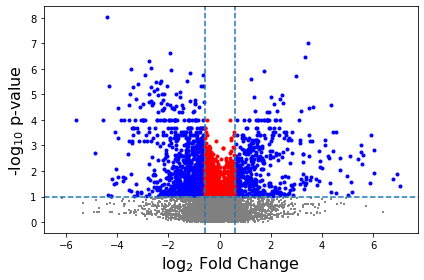

In [23]:
exp_data.label_free.volcano_plot();

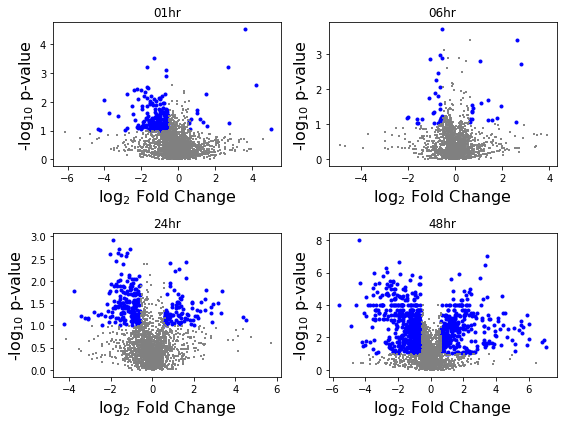

In [24]:
exp_data.label_free.volcano_by_sample(sig_column=True);

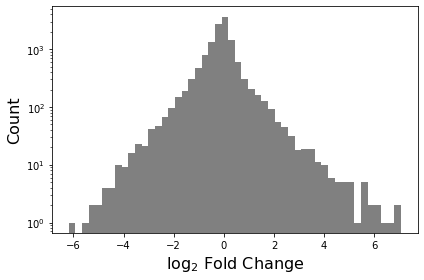

In [25]:
exp_data.label_free.plot_histogram();

### Plotting subset of species

We provide the a few plotting interfaces to explore that subsets of the data. Basically, you create a list of species and provide it to the function. It filters based on these and then returns the results. 


#### Time series using plot'y or matplotlib

In [26]:
exp_data.label_free.plot_species(['LMNA', 'VDAC1'], plot_type='plotly')

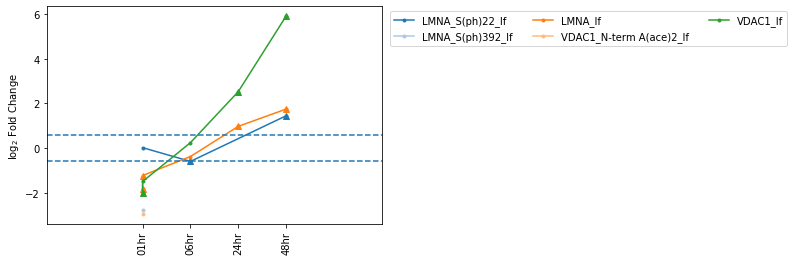

In [27]:
exp_data.label_free.plot_species(['LMNA', 'VDAC1'], plot_type='matplotlib');

#### Heatplots

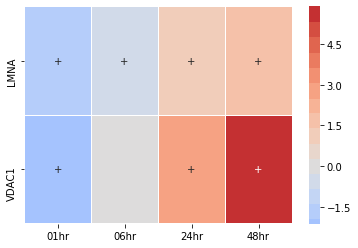

In [28]:
exp_data.label_free.heatmap(
    ['LMNA', 'VDAC1'], 
    figsize=(6,4), 
    linewidths=0.01
);

Notice that the above plot doesn't show any of the modifiers of LMBA (no _s(ph)22_lf). This is because the default index to pivot plots is the `identifier` column. You can set the `label` column for plotting by passing index=`label` to the function. Note, if you want to filter the data using the more generic 'identifier' column, you just specify that with subset_index='identifier'

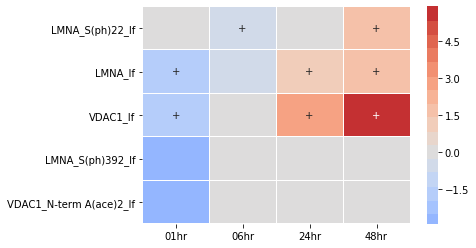

In [31]:
exp_data.label_free.heatmap(
    ['LMNA', 'VDAC1'], 
    subset_index='identifier', 
    index='label',
    figsize=(6,4), 
    linewidths=0.01
);

### Examples

Here are a few examples how all the above commands can be chained together to create plots with varying degrees of critera. 


#### Query 1: 
    Heatmap of label-free proteomics that are signficantly change in at least 3 time points.

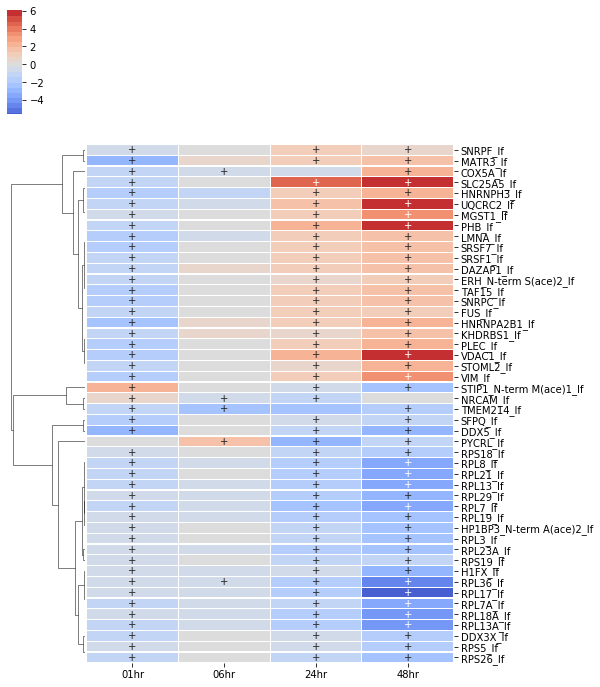

In [30]:
lf_sig = exp_data.label_free.require_n_sig(
    index='label', 
    columns='sample_id', 
    n_sig=3
).heatmap(
    convert_to_log=True, 
    cluster_row=True, 
    index='label',
    values='fold_change', 
    columns='sample_id', 
    annotate_sig=True, 
    figsize=(8, 12), 
    div_colors=True,
    num_colors=21, 
    linewidths=0.01
);

#### Query 2: 
    Changes that happen at all 3 timepoints for RNA-seq.

In [31]:
exp_data.rna.require_n_sig(n_sig=3, index='label').plot_species(plot_type='plotly');

#### Query 3: 
* Heatmap and time series plot of proteins that are consistently down regulated at 3 time points. 

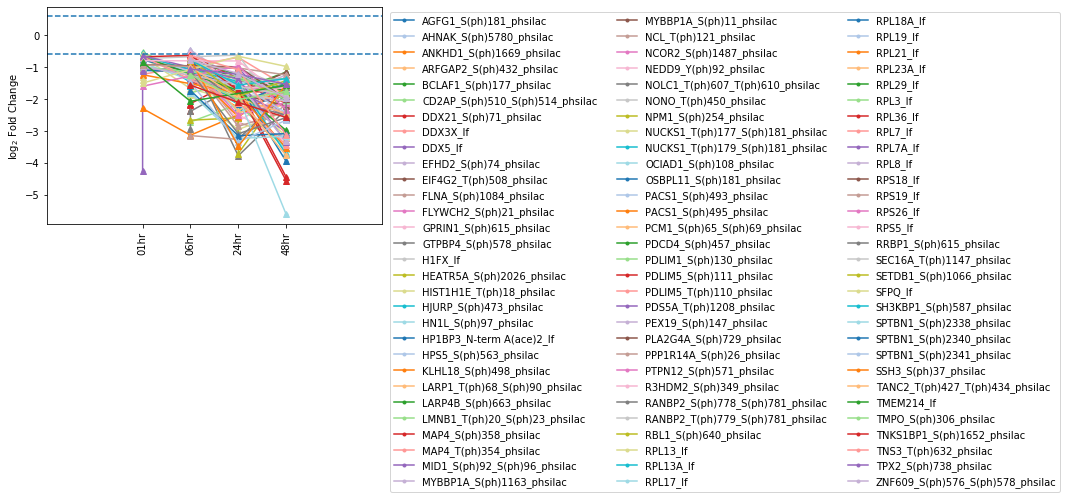

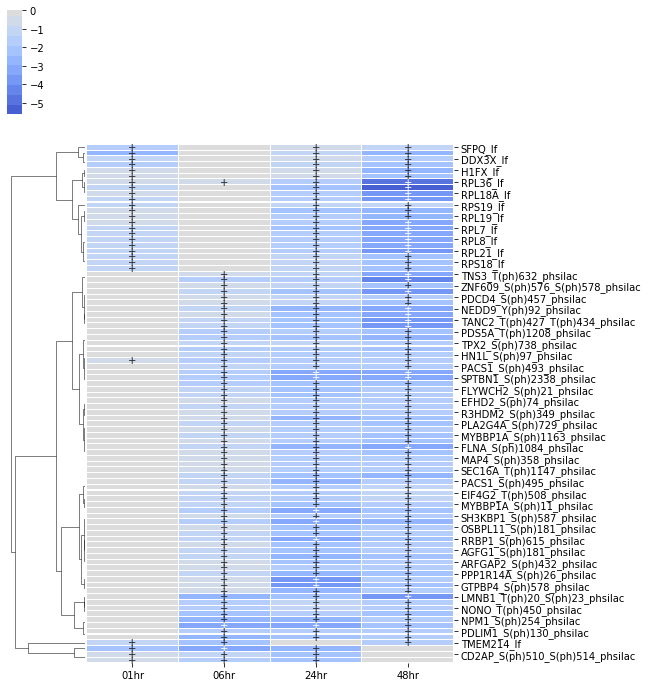

In [32]:
exp_data.proteins.down.require_n_sig(n_sig=3, index='label').plot_species(plot_type='matplotlib');
exp_data.proteins.down.require_n_sig(n_sig=3, index='label').heatmap(index='label', cluster_row=True, linewidths=0.01);

#### Query 4: 
    Clustered heatmap of label-free data

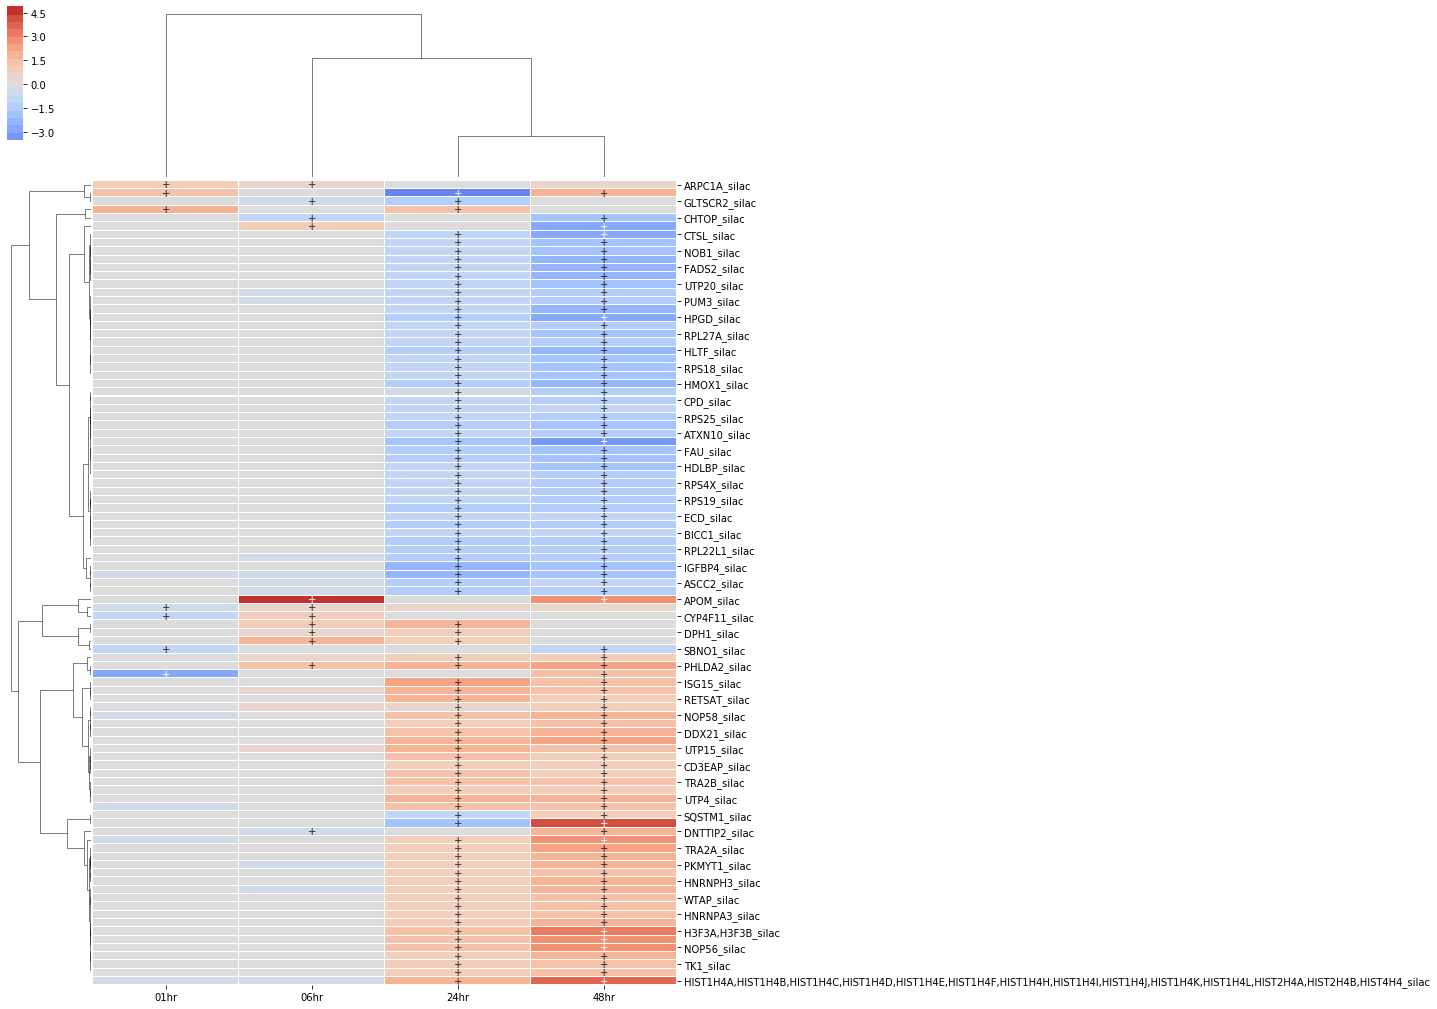

In [34]:
exp_data.silac.heatmap(
    linewidths=0.01,
    index='label',
    cluster_row=True, 
    cluster_col=True, 
    min_sig=2, 
    figsize=(12,18)
);

### Extending to other plots

Since our exp_data is built off a pandas.DataFrame, we can use other packages that take that data format. Seaborn is one such tool that provides some very nice plots.

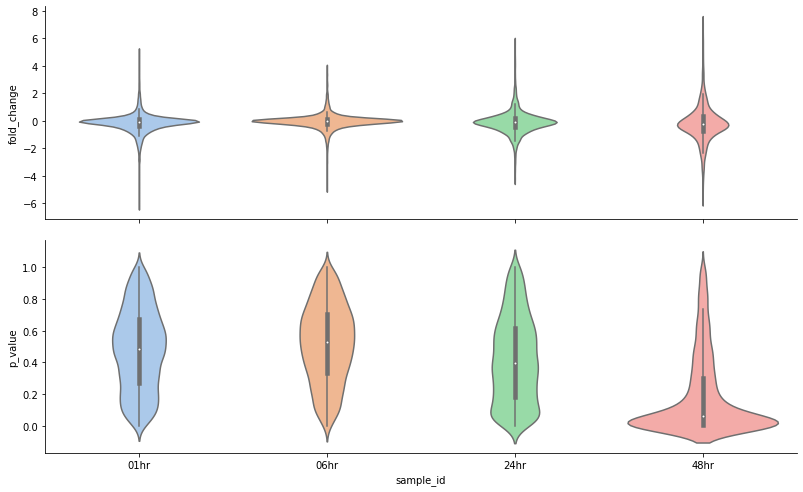

In [35]:
label_free = exp_data.label_free.copy()
label_free.log2_normalize_df(column='fold_change', inplace=True)

g = sns.PairGrid(label_free,
                 x_vars=('sample_id'),
                 y_vars=('fold_change', 'p_value'),
                 aspect=3.25, height=3.5)
g.map(
    sns.violinplot, 
    palette="pastel", 
    order=label_free.sample_ids
);

#### Venn diagram comparisons between measurements

In [ ]:
from magine.plotting.venn_diagram_maker import create_venn2, create_venn3

In [42]:
lf = exp_data.label_free.sig

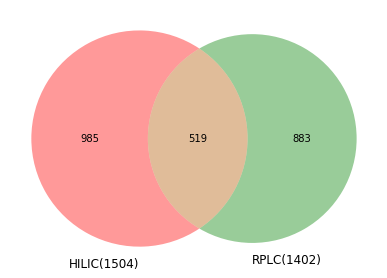

In [43]:
lf = exp_data.label_free.sig.id_list
silac = exp_data.silac.sig.id_list
phsilac = exp_data.ph_silac.sig.id_list
hilic = exp_data.HILIC.sig.id_list
rplc = exp_data.C18.sig.id_list

create_venn2(hilic, rplc, 'HILIC', 'RPLC');

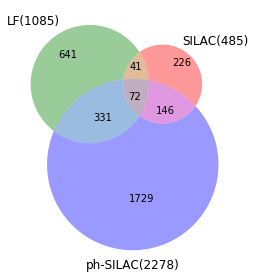

In [44]:
create_venn3(lf, silac, phsilac, 'LF', 'SILAC', 'ph-SILAC');

## Networks

### Create data driven network

MAGINE generates networks using seed species. It located the seed species in multiple databases and finds interconnecting edges among them. The goal of this process was to obtain all the `known` biological regulation among the species. We currently utilize KEGG, Reactome, HMDB, TTRUST, and BioGrid for node and edge sources. 

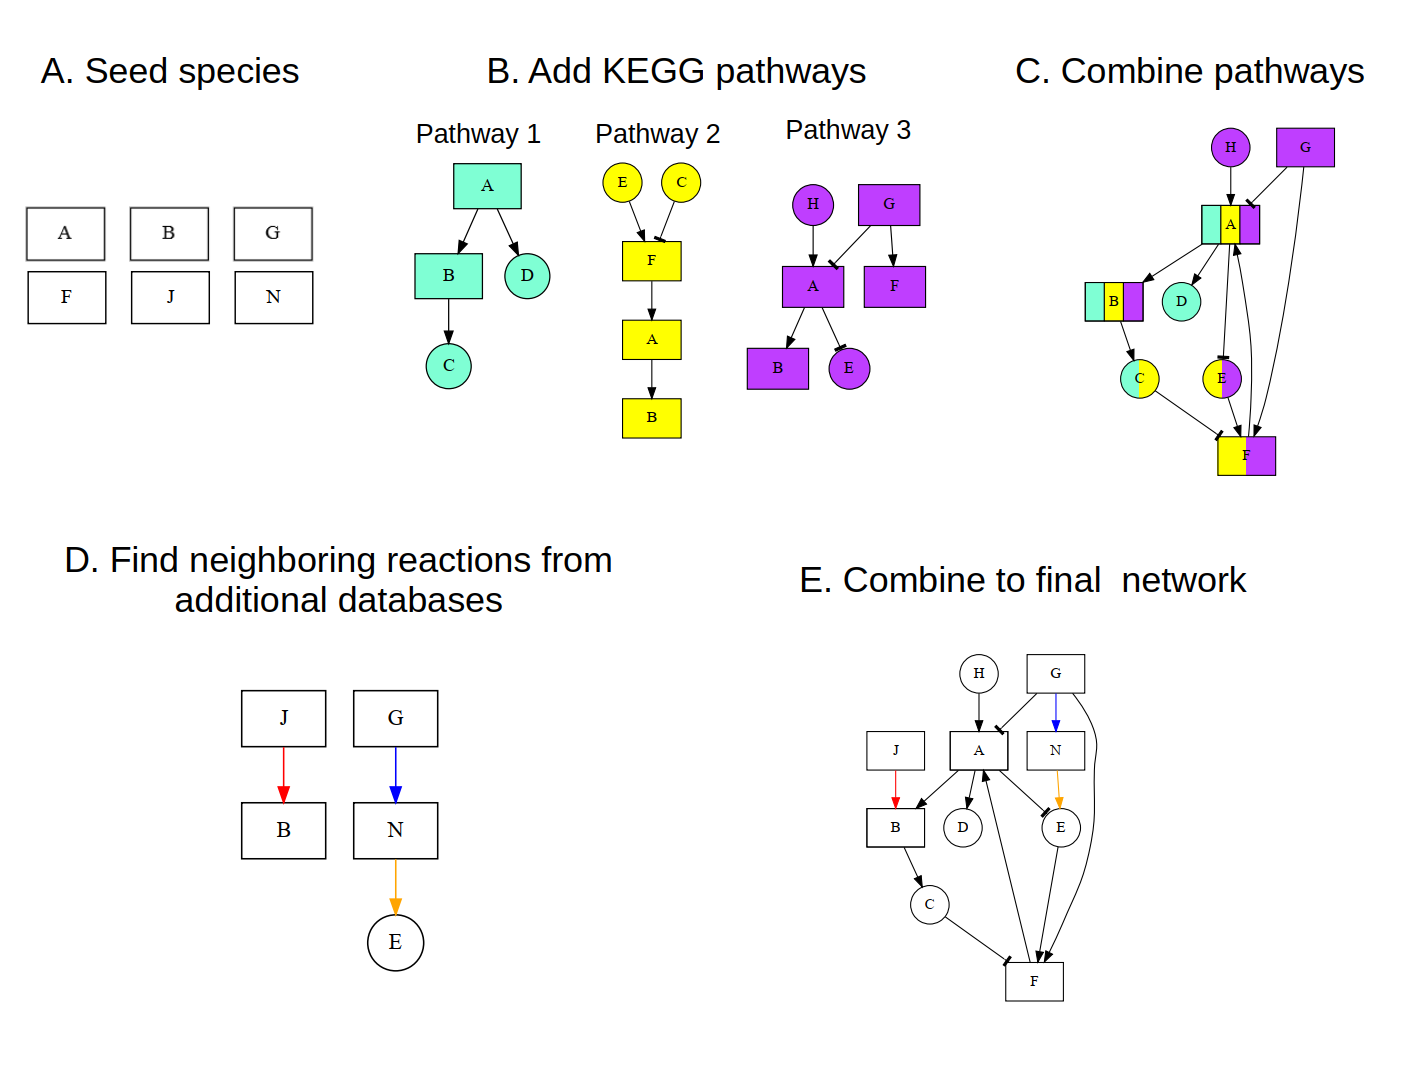

In [39]:
Image('network_creation_steps.png')

In [45]:
# some imports needed
from magine.networks.network_generator import build_network
import magine.networks.utils as utils
import networkx as nx
import os

2020-10-08 13:01:37.450 - magine - INFO - Logging started on MAGINE version 0.1.2
2020-10-08 13:01:37.452 - magine - INFO - Log entry time offset from UTC: -7.00 hours


This is done using the `build_network` function. 
Now we will create the network. We pass the seed and background list to the network as well as flags turning on all of the network databases. We also trim source/sink nodes (this basically cleans up dangling nodes that are not in our seed or background lists).

In [46]:
measured = exp_data.species.id_list
sig_measured = exp_data.species.sig.id_list
print(len(measured))
print(len(sig_measured))

23725
15777


In [47]:
if not os.path.exists('Data/cisplatin_network.p'):
    network = build_network(
        
        # genes seed species
        seed_species=sig_measured, 
        
        # all data measured, used to allow interconnecting nodes that are not in seeds.
        all_measured_list=measured,  
        
        use_biogrid=True,  # expand with biogrid
        use_hmdb=True,  # expand with hmdb
        use_reactome=True,  # expand with reactome
        use_signor=True,  # expand with signor
        trim_source_sink=True,  # remove all source and sink nodes not measured
        save_name='Data/cisplatin_network'
    )
else:
    # Load the network, note that it is returned above but for time limits,
    # we will just load the generated one.
    network = nx.read_gpickle('Data/cisplatin_network.p')

# add attibutes to graph nodes (measured, measured at which time points, 
# significantly changed at which time point)
utils.add_data_to_graph(network, exp_data)
print("Saving network")
# write to GML for cytoscape or other program
nx.write_gml(
    network,
    os.path.join('Data', 'cisplatin_network_w_attributes.gml')
)

# write to gpickle for fast loading in python
nx.write_gpickle(
    network,
    os.path.join('Data', 'cisplatin_based_network.p'),
)

Saving network


In [48]:
print(network.number_of_nodes())
print(network.number_of_edges())

13308
181300


As you might iMAGINE, the larger number of input nodes and source databases, the larger the resulting network. 13308 nodes and 181300 edges are too much to manually explore. Thus, we are going to use the `Subgraph` Class to being to query the network. We developed multiple tools to subgraph and explore the network, as well as multiple visualizations.

### Explore subgraphs of network

In [49]:
from magine.networks.subgraphs import Subgraph
from magine.networks.visualization import draw_igraph, draw_graphviz, draw_mpl, draw_cyjs
net_sub = Subgraph(network)
help(net_sub)

Help on Subgraph in module magine.networks.subgraphs object:

class Subgraph(builtins.object)
 |  Subgraph(network, exp_data=None, pool=None)
 |  
 |  Methods defined here:
 |  
 |  __init__(self, network, exp_data=None, pool=None)
 |      Generates network subgraphs
 |      
 |      Parameters
 |      ----------
 |      network : networkx.DiGraph
 |      exp_data : magine.data.datatypes.ExperimentalData
 |  
 |  downstream_of_node(self, species_1, include_list=None, save_name=None, draw=False)
 |      Generate network of all downstream species of provides species
 |      
 |      
 |      Parameters
 |      ----------
 |      species_1 : str
 |          species name
 |      save_name : str
 |          name to save gml file
 |      draw : bool
 |          create figure of graph
 |      include_list : list_like
 |          list of species that must be in path in order to consider a path
 |      Returns
 |      -------
 |      nx.DiGraph
 |      
 |      
 |      Examples
 |      -------

In [51]:
bax_neighbors = net_sub.neighbors(
    'BAX', # node of interest
    upstream=True, # include upstream nodes
    downstream=False,  # include downstream nodes
    include_only=exp_data.species.sig.id_list # limit nodes to only significant changed species
)

There are multiple ways to visualize the network.
draw_igraph, draw_mpl, draw_graphviz, draw_cyjs

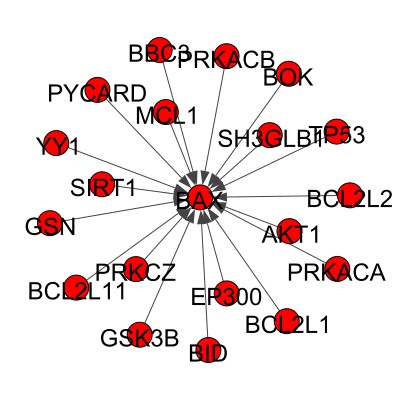

In [52]:
draw_igraph(bax_neighbors, bbox=[400, 400], node_size=25, inline=True)

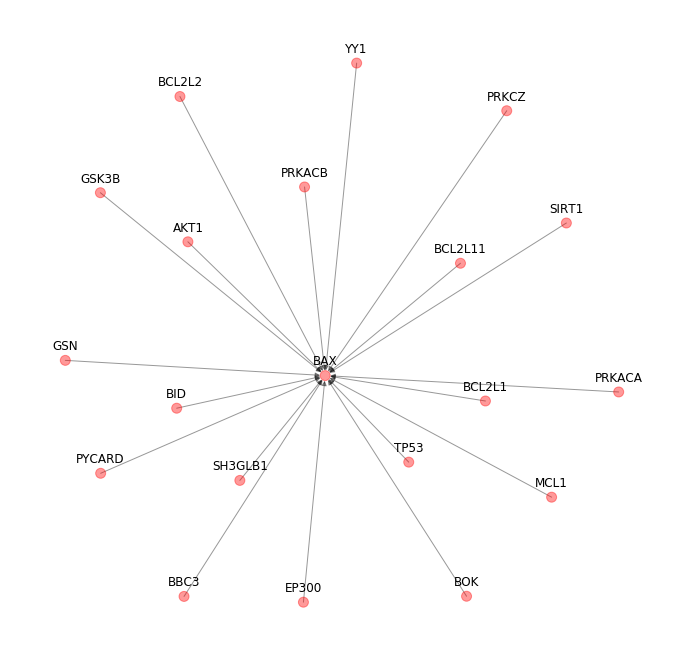

In [53]:
draw_mpl(bax_neighbors, layout='fdp', scale=3, node_size=100, font_size=12);

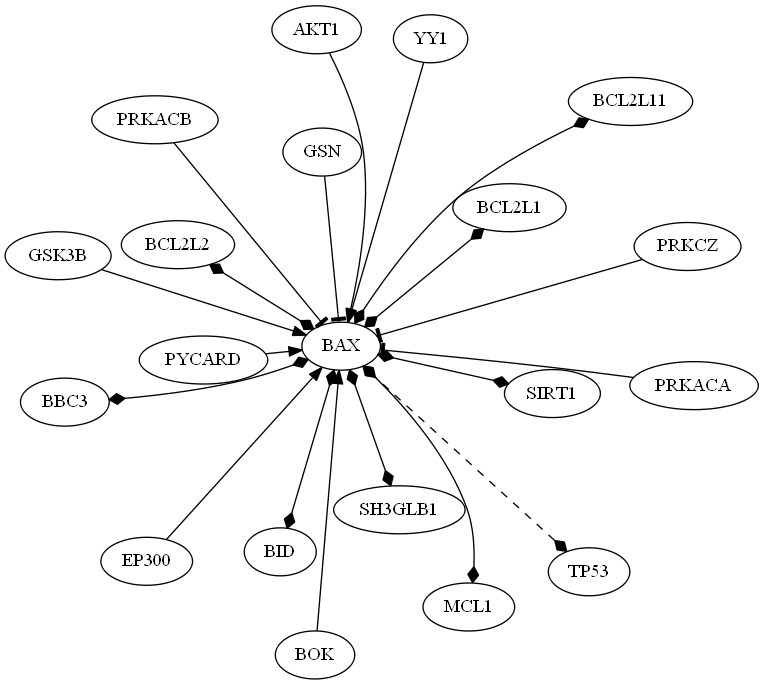

In [54]:
draw_graphviz(bax_neighbors, 'fdp')

In [55]:
draw_cyjs(bax_neighbors)

This network can be exanded by a single or list of nodes passed.

In [56]:
expand = net_sub.expand_neighbors(bax_neighbors, nodes='BID', downstream=True)

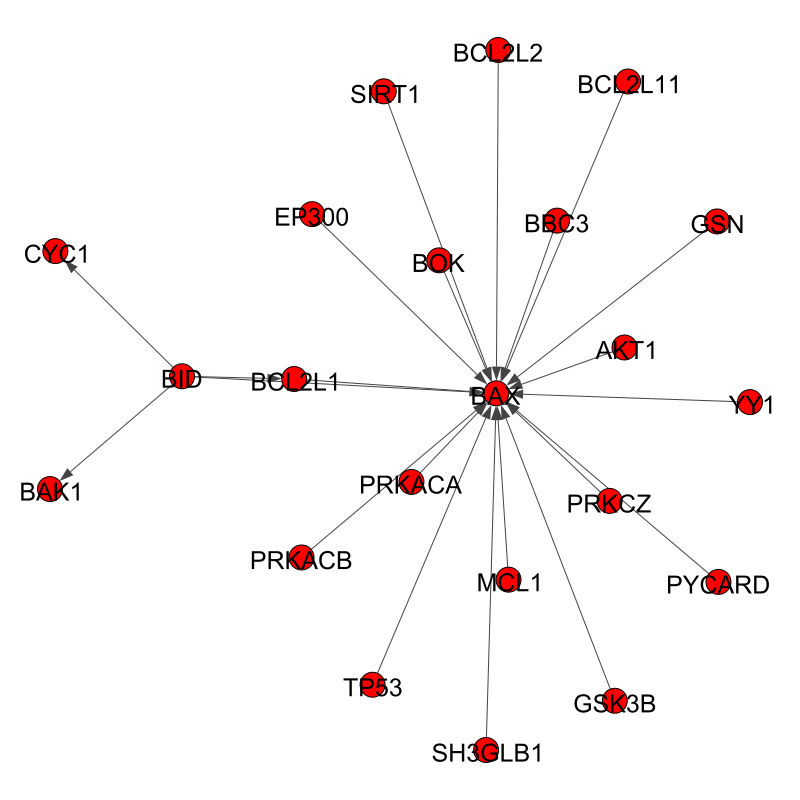

In [57]:
draw_igraph(expand, 
            bbox=[800, 800], 
            node_font_size=25,
            font_size=4,
            node_size=25, 
            inline=True, 
            layout='graphopt')

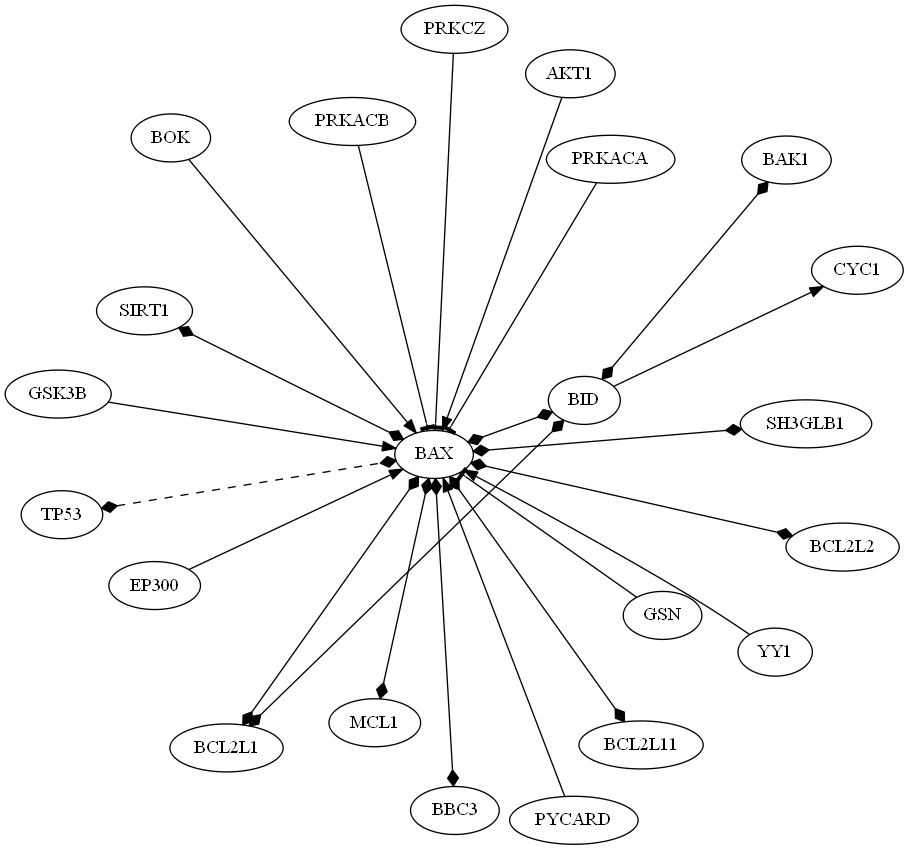

In [58]:
draw_graphviz(expand, 'sfdp', width=700)

#### Finding paths between two proteins

In [ ]:
BAX_to_AKT = net_sub.paths_between_pair('NOTCH1', 'MYC', bidirectional=True)

In [74]:
for i,j, d in BAX_to_AKT.edges(data=True):
    if 'expression' in d['interactionType']:
        print(i, j)

HEYL MYC
JUN MYC
RBPJ MYC
NOTCH1 HEYL
NOTCH1 HES1
NOTCH1 HEY2
NOTCH1 HES5
NOTCH1 HEY1
HEY2 MYC
HES5 MYC
HEY1 MYC
CTNNB1 MYC
HES1 MYC
RBPJL MYC


In [ ]:
draw_graphviz(BAX_to_AKT)

In [69]:
draw_cyjs(BAX_to_AKT)

### Running enrichment analysis via EnrichR

MAGINE automates the upload samples to EnrichR and collated the results into a user friends format (`EnrichmentResult` Class).


In [63]:
from magine.enrichment.enrichr import Enrichr

In [64]:
e = Enrichr()

In [76]:
ph_silac_enrichment = e.run_samples(
    exp_data.ph_silac.sig.up_by_sample, 
    exp_data.ph_silac.sig.sample_ids,
    gene_set_lib='Reactome_2016'
)

In [77]:
ph_silac_enrichment.head(10)

,term_name,rank,p_value,z_score,combined_score,adj_p_value,genes,n_genes,db,significant,sample_id
0,cell cycle_hsa-1640170,1,6.097256e-07,3.022131,43.247475,0.000933,"ACD,AKAP9,BRCA1,CDC16,CDC20,CDC7,CLASP2,DCTN1,...",26,Reactome_2016,True,01hr
1,interleukin-2 signaling_hsa-451927,2,1.697041e-06,4.177109,55.499684,0.001298,"AKAP9,BRAF,CNKSR2,CUL3,HAVCR2,INPPL1,IRS2,MAPK...",16,Reactome_2016,True,01hr
2,"interleukin-3, 5 and gm-csf signaling_hsa-512988",3,2.677495e-06,4.033071,51.746840,0.001366,"AKAP9,BRAF,CNKSR2,CUL3,INPPL1,IRS2,MAPK3,MARK3...",16,Reactome_2016,True,01hr
3,interleukin receptor shc signaling_hsa-912526,4,5.589099e-06,4.027927,48.716538,0.002138,"AKAP9,BRAF,CNKSR2,CUL3,INPPL1,IRS2,MAPK3,MARK3...",15,Reactome_2016,True,01hr
4,signalling by ngf_hsa-166520,5,5.968762e-06,3.070175,36.931051,0.001826,"AKAP13,AKAP9,ARHGEF16,BRAF,CNKSR2,CUL3,HDAC1,I...",21,Reactome_2016,True,01hr
5,mapk family signaling cascades_hsa-5683057,6,7.859464e-06,3.706449,43.564834,0.002004,"AKAP9,BRAF,CNKSR2,CUL3,DNAJB1,IRS2,MAPK3,MARK3...",16,Reactome_2016,True,01hr
6,insulin receptor signalling cascade_hsa-74751,7,8.967430e-06,3.667706,42.625753,0.001960,"AKAP9,BRAF,CNKSR2,CUL3,INSR,IRS2,MAPK3,MARK3,P...",16,Reactome_2016,True,01hr
7,signaling by interleukins_hsa-449147,8,9.805077e-06,3.188776,36.774905,0.001875,"AKAP9,BRAF,CNKSR2,CUL3,HAVCR2,INPPL1,IRS2,MAP3...",19,Reactome_2016,True,01hr
8,signal attenuation_hsa-74749,9,1.022501e-05,26.315789,302.386159,0.001738,"INSR,IRS2,MAPK3,SHC1",4,Reactome_2016,True,01hr
9,signaling by fgfr2_hsa-5654738,10,1.150341e-05,3.280362,37.307117,0.001760,"AKAP9,BRAF,CNKSR2,CUL3,HNRNPA1,HNRNPM,INSR,IRS...",18,Reactome_2016,True,01hr


In [78]:
# clean up naming of terms
ph_silac_enrichment.term_name = ph_silac_enrichment.term_name.str.split('_').str.get(0)

In [60]:
ph_silac_enrichment.head(10)

,term_name,rank,p_value,z_score,combined_score,adj_p_value,genes,n_genes,db,significant,sample_id
0,cell cycle,1,6.097256e-07,3.022131,43.247475,0.000933,"ACD,AKAP9,BRCA1,CDC16,CDC20,CDC7,CLASP2,DCTN1,...",26,Reactome_2016,True,01hr
1,interleukin-2 signaling,2,1.697041e-06,4.177109,55.499684,0.001298,"AKAP9,BRAF,CNKSR2,CUL3,HAVCR2,INPPL1,IRS2,MAPK...",16,Reactome_2016,True,01hr
2,"interleukin-3, 5 and gm-csf signaling",3,2.677495e-06,4.033071,51.746840,0.001366,"AKAP9,BRAF,CNKSR2,CUL3,INPPL1,IRS2,MAPK3,MARK3...",16,Reactome_2016,True,01hr
3,interleukin receptor shc signaling,4,5.589099e-06,4.027927,48.716538,0.002138,"AKAP9,BRAF,CNKSR2,CUL3,INPPL1,IRS2,MAPK3,MARK3...",15,Reactome_2016,True,01hr
4,signalling by ngf,5,5.968762e-06,3.070175,36.931051,0.001826,"AKAP13,AKAP9,ARHGEF16,BRAF,CNKSR2,CUL3,HDAC1,I...",21,Reactome_2016,True,01hr
5,mapk family signaling cascades,6,7.859464e-06,3.706449,43.564834,0.002004,"AKAP9,BRAF,CNKSR2,CUL3,DNAJB1,IRS2,MAPK3,MARK3...",16,Reactome_2016,True,01hr
6,insulin receptor signalling cascade,7,8.967430e-06,3.667706,42.625753,0.001960,"AKAP9,BRAF,CNKSR2,CUL3,INSR,IRS2,MAPK3,MARK3,P...",16,Reactome_2016,True,01hr
7,signaling by interleukins,8,9.805077e-06,3.188776,36.774905,0.001875,"AKAP9,BRAF,CNKSR2,CUL3,HAVCR2,INPPL1,IRS2,MAP3...",19,Reactome_2016,True,01hr
8,signal attenuation,9,1.022501e-05,26.315789,302.386159,0.001738,"INSR,IRS2,MAPK3,SHC1",4,Reactome_2016,True,01hr
9,signaling by fgfr2,10,1.150341e-05,3.280362,37.307117,0.001760,"AKAP9,BRAF,CNKSR2,CUL3,HNRNPA1,HNRNPM,INSR,IRS...",18,Reactome_2016,True,01hr


The `EnrichmentResult` Class shares the same plotting format as the `ExperimentalData` Class.

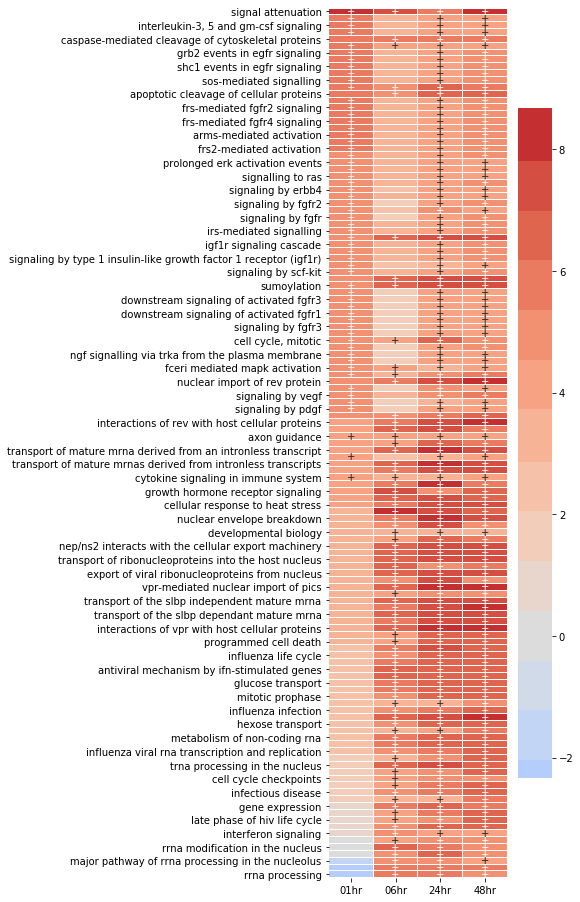

In [80]:
ph_silac_enrichment.heatmap(
    min_sig=3, 
    figsize=(4,16),
    linewidths=0.01,
    cluster_by_set=False
);

In [81]:
print(len(ph_silac_enrichment.sig.term_name.unique()))

315


In [82]:
display(sorted(ph_silac_enrichment.sig.term_name.unique()))

['2-ltr circle formation',
 "3' -utr-mediated translational regulation",
 'activation of bad and translocation to mitochondria',
 'activation of bh3-only proteins',
 'activation of the ap-1 family of transcription factors',
 'activation of the mrna upon binding of the cap-binding complex and eifs, and subsequent binding to 43s',
 'akt phosphorylates targets in the cytosol',
 'antiviral mechanism by ifn-stimulated genes',
 'apobec3g mediated resistance to hiv-1 infection',
 'apoptosis',
 'apoptotic cleavage of cellular proteins',
 'apoptotic execution  phase',
 'arms-mediated activation',
 'assembly of the pre-replicative complex',
 'asymmetric localization of pcp proteins',
 'auf1 (hnrnp d0) binds and destabilizes mrna',
 'autodegradation of cdh1 by cdh1:apc/c',
 'autodegradation of the e3 ubiquitin ligase cop1',
 'axon guidance',
 'basigin interactions',
 'beta-catenin phosphorylation cascade',
 'cap-dependent translation initiation',
 'caspase-mediated cleavage of cytoskeletal protei

There are 315 enriched terms. If we look at the top ranked terms, we see that some fo them have similar descriptions ".... fgfr signaling". If we look at the gene list, we can also see that some of the genes are similar. To see if there are redundant terms that are enriched, we can calculate their similarity with the Jaccard Index (intersection over union).
![width=50](https://wikimedia.org/api/rest_v1/media/math/render/svg/eaef5aa86949f49e7dc6b9c8c3dd8b233332c9e7)
<img src="https://upload.wikimedia.org/wikipedia/commons/c/c7/Intersection_over_Union_-_visual_equation.png" alt="Drawing" style="width: 300px;"/>

In [83]:
# calculate the Jaccard Index and returns a ranked dataframe of terms and scores.
# Higher scores means more similar terms
d = ph_silac_enrichment.find_similar_terms('regulation of tp53 activity')
display(d.head(20))

,term_name,similarity_score
251,tp53 regulates transcription of dna repair genes,1.000000
1108,regulation of tp53 activity through phosphoryl...,1.000000
869,sumoylation of transcription factors,1.000000
422,hdr through mmej (alt-nhej),1.000000
1109,hdr through mmej (alt-nhej),1.000000
318,regulation of tp53 activity through phosphoryl...,1.000000
225,regulation of tp53 activity through phosphoryl...,1.000000
778,regulation of tp53 activity through phosphoryl...,1.000000
552,intrinsic pathway for apoptosis,1.000000
518,activation of bh3-only proteins,1.000000


We can do this for all terms and view the results in a distance matrix (plot used for visualization purpose only).

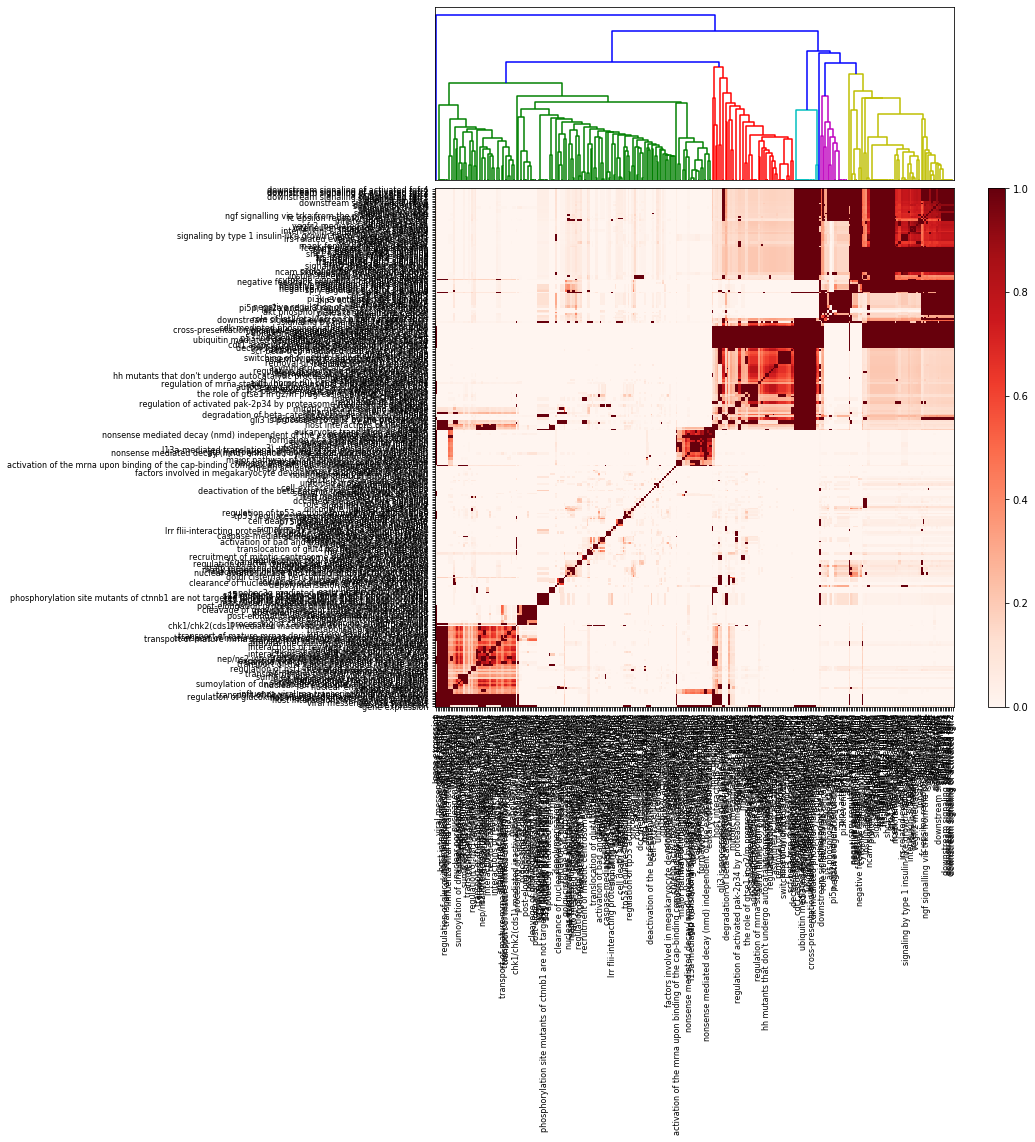

In [84]:
ph_silac_enrichment.dist_matrix(figsize=(12, 12));

We can remove the redundant ones to compress the array. Here, we sort the terms by combined_score. For each term, we calculate the Jaccard index with all other terms. If a term falls below above a user defined threshold, it will be removed in the resulting array. By doing so, we minimize the total number of terms, while maximizing the information content of the resulting array.

In [85]:
ph_silac_enrichment_slim = ph_silac_enrichment.remove_redundant(level='dataframe')

Number of rows went from 315 to 84


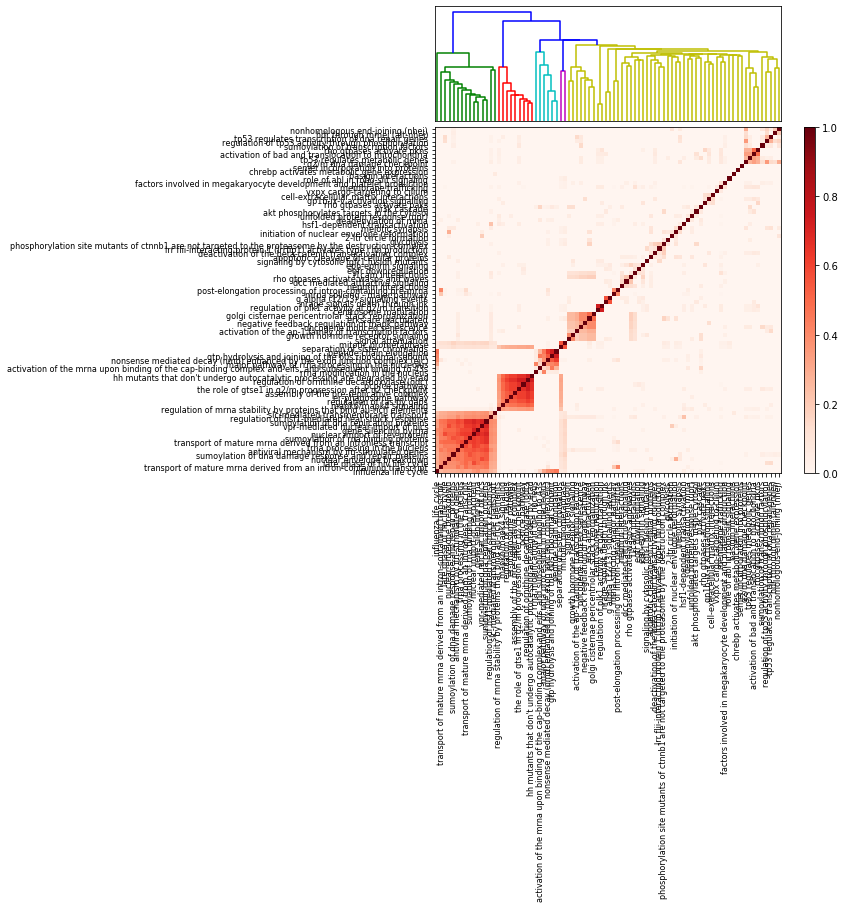

In [86]:
# notive the reduction in size and overlap of terms
ph_silac_enrichment_slim.dist_matrix();

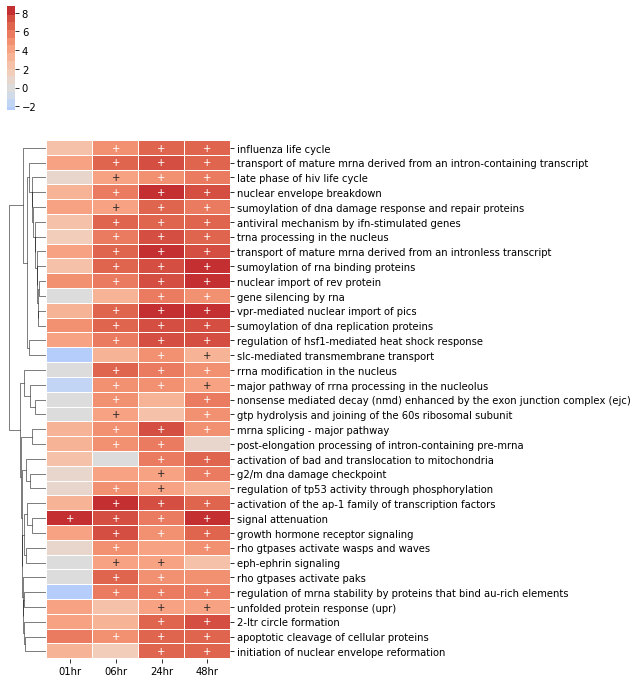

In [87]:
ph_silac_enrichment_slim.heatmap(
    min_sig=2, 
    figsize=(4,12),
    linewidths=0.01,
    cluster_by_set=True
);

Important to known, we can still recover the terms removed based on the highest level term kept.

Number of rows went from 315 to 79


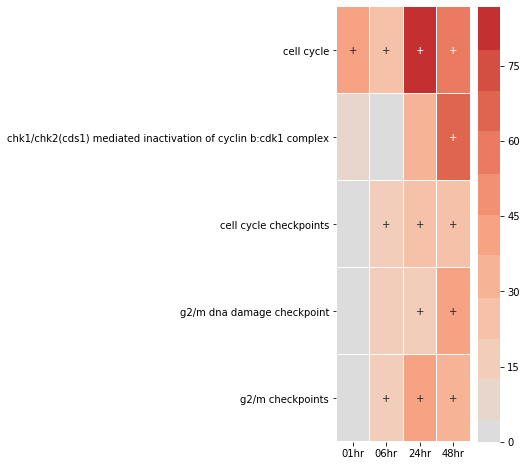

In [88]:
ph_silac_enrichment.show_terms_below('g2/m dna damage checkpoint').heatmap(
    linewidths=0.01, 
    convert_to_log=False,
    figsize=(3, 8));

In [89]:
display(sorted(ph_silac_enrichment_slim.term_name.unique()))

['2-ltr circle formation',
 'activation of bad and translocation to mitochondria',
 'activation of the ap-1 family of transcription factors',
 'activation of the mrna upon binding of the cap-binding complex and eifs, and subsequent binding to 43s',
 'akt phosphorylates targets in the cytosol',
 'antiviral mechanism by ifn-stimulated genes',
 'apoptotic cleavage of cellular proteins',
 'assembly of the pre-replicative complex',
 'basigin interactions',
 'cell-extracellular matrix interactions',
 'centrosome maturation',
 'chrebp activates metabolic gene expression',
 'dcc mediated attractive signaling',
 'deactivation of the beta-catenin transactivating complex',
 'deadenylation of mrna',
 'egfr downregulation',
 'eph-ephrin signaling',
 'er-phagosome pathway',
 'erks are inactivated',
 'factors involved in megakaryocyte development and platelet production',
 'g alpha (12/13) signalling events',
 'g2/m dna damage checkpoint',
 'gene silencing by rna',
 'glycolysis',
 'golgi cisternae pe

We can use the EnrichmentResult to extract out any given set of genes for a term (or the entire array). 
For a select term, we can extract out the species of interest to visualize. This makes chaining together the data, networks, and enrichment output seamlessly.

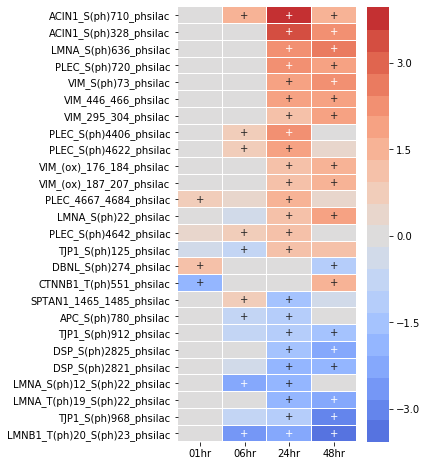

In [94]:
exp_data.ph_silac.heatmap(
    ph_silac_enrichment_slim.sig.term_to_genes('apoptotic cleavage of cellular proteins'),
    subset_index='identifier',
    index='label',
    cluster_row=False,
    sort_row='mean',
    min_sig=2,
    linewidths=0.01,
    figsize=(4, 8),
);

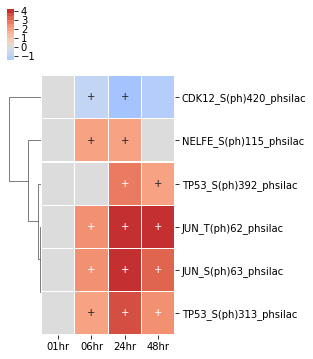

In [95]:
exp_data.ph_silac.heatmap(
    ph_silac_enrichment_slim.sig.term_to_genes('tp53 regulates transcription of dna repair genes'),
    subset_index='identifier',
    index='label',
    cluster_row=True,
    sort_row='index',
    min_sig=2,
    linewidths=0.01,
    figsize=(3, 6),
);

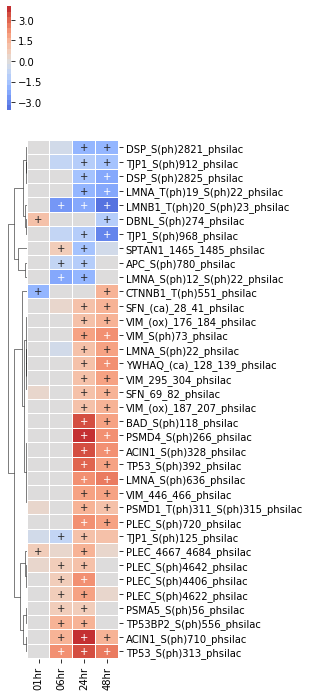

In [73]:
exp_data.ph_silac.heatmap(
    ph_silac_enrichment.sig.term_to_genes('apoptosis'),
    subset_index='identifier',
    index='label',
    cluster_row=True,
    sort_row='index',
    min_sig=2,
    linewidths=0.01,
    figsize=(2,12),
);

##### We can use the ExperimentalData class to filter the data to create lists of genes for further analysis. We take these lists and run enrichment analysis using Enrichr. 

<img src="magine_enrichment.png" alt="Drawing" style="width: 800px;"/>


Since this part is time consuming, it is best to do it outside of a notebook. The code to do so can be found in "run_enrichment.py". The results will be a csv file that we will load next.

## Annotated Gene set Network (AGN)
Lastly, we created a function to generate molecular and coarse grain networks based on enrichment terms. Users can used the compressed enrichment result terms to generate large scale representations of their data, or by selecting key terms of importance. Here, we are going to use 3 terms from the compressed enrichment result class.

In [96]:
from magine.networks.annotated_set import create_subnetwork
# selected terms of interest
terms=['g2/m dna damage checkpoint', 
       'apoptotic cleavage of cellular proteins',
       'regulation of tp53 activity through phosphorylation']

term_net, mol_net = create_subnetwork( 
    ph_silac_enrichment_slim, network,
    terms=terms,
    save_name='all_example',
    use_threshold=True,
    use_cytoscape=False, # If you have cytoscape open, this will create a cytoscape session if True
)

Creating ontology network


In [97]:
draw_cyjs(term_net)

In [98]:
draw_cyjs(mol_net, add_parent=True)

In [99]:
draw_cyjs(mol_net, add_parent=False)

Finally, we can bring it full circle and subset our experimental data to visualize the nodes in the networks measured values over time.

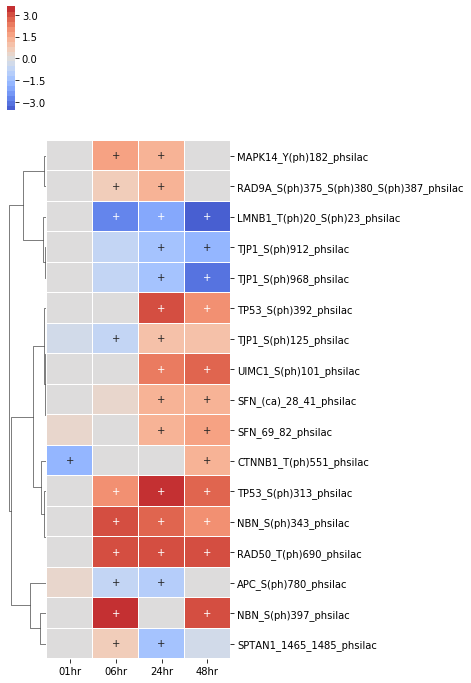

In [78]:
exp_data.ph_silac.heatmap(
    mol_net.nodes,
    subset_index='identifier',
    index='label',
    cluster_row=True,
    sort_row='index',
    min_sig=2,
    linewidths=0.01,
    figsize=(4,12),
);
    

It is important to note that MAGINE provides a suite of tools that can be used to automate and consturct custom pipelines. What is shown in this tutorial is just a subset of the possibly pipelines one can build. You can contact james.c.pino@vanderbilt.edu or alex.lubbock@vanderbilt.edu if you have any other questions.